#### Import Libraries

In [701]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import ipywidgets as widgets
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pandas_profiling import ProfileReport

from summarytools import dfSummary

import plotly.io as pio

In [702]:
# To render plotly into GitHub
pio.renderers.default = "svg"

In [703]:
# Select country in analysys ('FIN', 'DEN', 'NOR', 'SWE')
country = 'SWE'

### Load data

In [704]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date").asfreq('MS')

In [705]:
df

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01-01,110,0.611753,8.1,3.32,63.568847
2006-02-01,303,0.608882,7.3,3.42,67.391665
2006-03-01,634,1.122431,7.6,3.55,92.858327
2006-04-01,1097,1.484866,8.0,3.84,95.325089
2006-05-01,926,1.573034,7.4,3.89,107.940718
...,...,...,...,...,...
2022-08-01,744,9.831681,7.0,1.61,71.260900
2022-09-01,666,10.837620,7.1,2.08,76.413249
2022-10-01,711,10.853250,7.7,2.20,76.986837


In [706]:
df.describe()

,Orders,CPI,UR,LTIR,TIV
count,204.000000,204.000000,204.000000,204.000000,204.000000
mean,804.750000,1.677467,7.621569,1.781569,89.423103
std,292.446469,2.086685,0.898288,1.411966,21.542311
min,110.000000,-1.871640,5.800000,-0.290000,41.016545
25%,634.000000,0.303343,6.900000,0.577500,75.448427
50%,804.500000,1.482136,7.700000,1.590000,88.339246
75%,992.000000,2.123759,8.200000,3.185000,101.288087
max,1739.000000,11.464530,9.500000,4.450000,223.974669


In [707]:
dep_var = 'Orders'  # Dependant variable

### Plot data

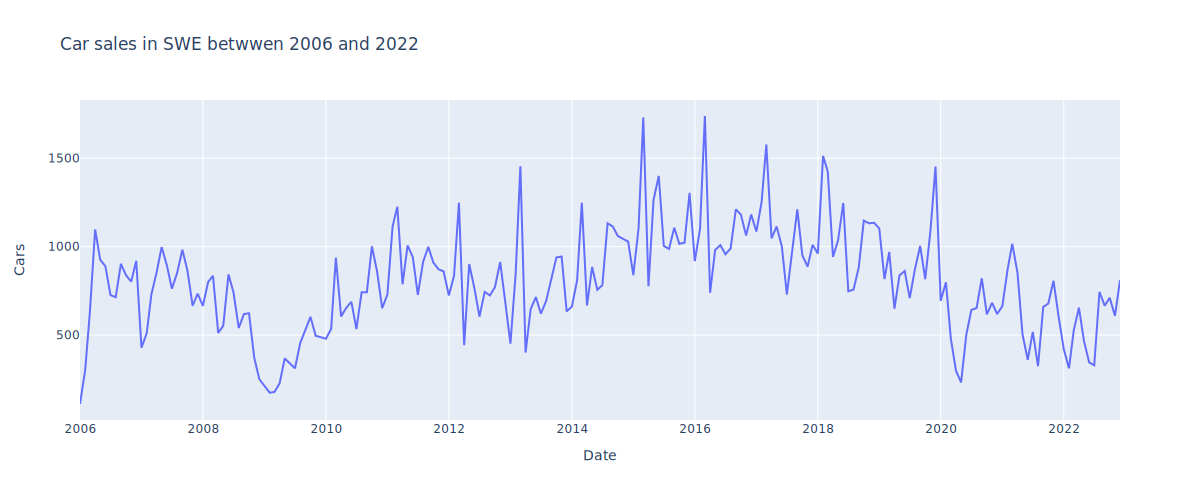

In [708]:
title = 'Car sales in ' + country + ' betwwen 2006 and 2022'

fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=df.index, y=df['Orders'], mode='lines')))

fig.update_layout(height=500, width=1200, title=go.layout.Title(text=title),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date')),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Cars')))

fig.update_xaxes(rangeslider_visible=False)
fig.show()

C:\Users\ne74255\AppData\Local\Temp/ipykernel_17528/1753767508.py:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



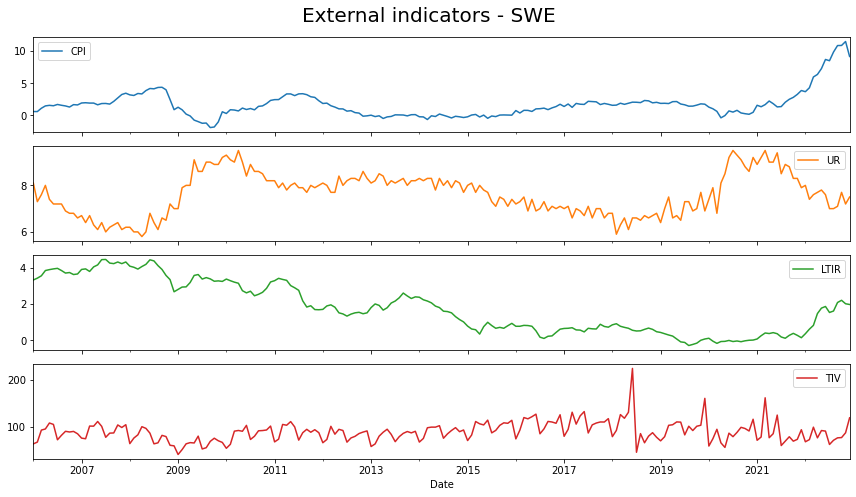

In [709]:
# Plot time series
fig, ax = plt.subplots(figsize=(12, 7))
df.iloc[:, 1:len(df.columns)].plot(
    legend   = True,
    subplots = True, 
    sharex   = True,
    ax       = ax, 
)
fig.suptitle('External indicators - ' + country, fontsize=20)
fig.tight_layout();

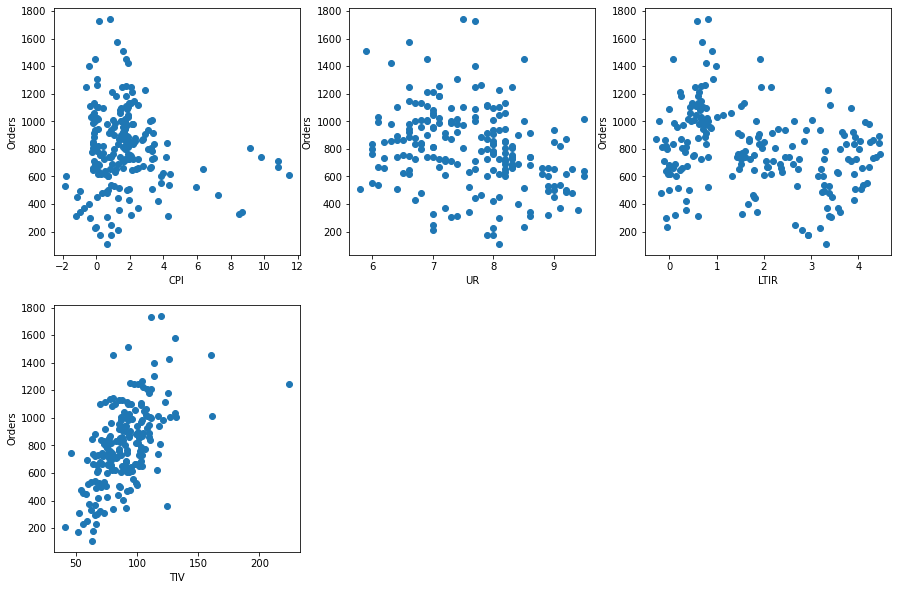

In [710]:
# Define a function to plot the scatterplots of the relationships between 
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):
    
    ind_var = df.loc[:, df.columns != dep_var]  # Independant variables
    figs = len(df.columns) - 1                  # Number of figures 

    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    
    fig = 1
    plt.figure(figsize=(15, 10))
    
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        plt.subplot(num_rows, num_cols, fig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(df,3)

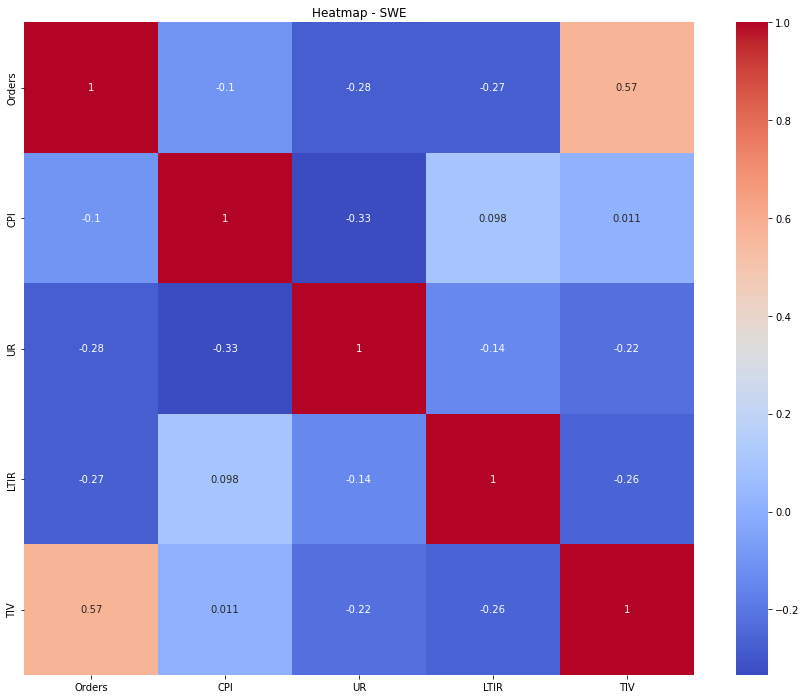

In [711]:
# Plot the correlations as a heatmap
plt.figure(figsize=(15, 12))
ax = plt.axes()
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2g', ax=ax)
ax.set_title('Heatmap - ' + country)
plt.show()

### Seasonality

It is observed that there is an annual seasonality, with higher (median) demand values in March (following the FY closing)

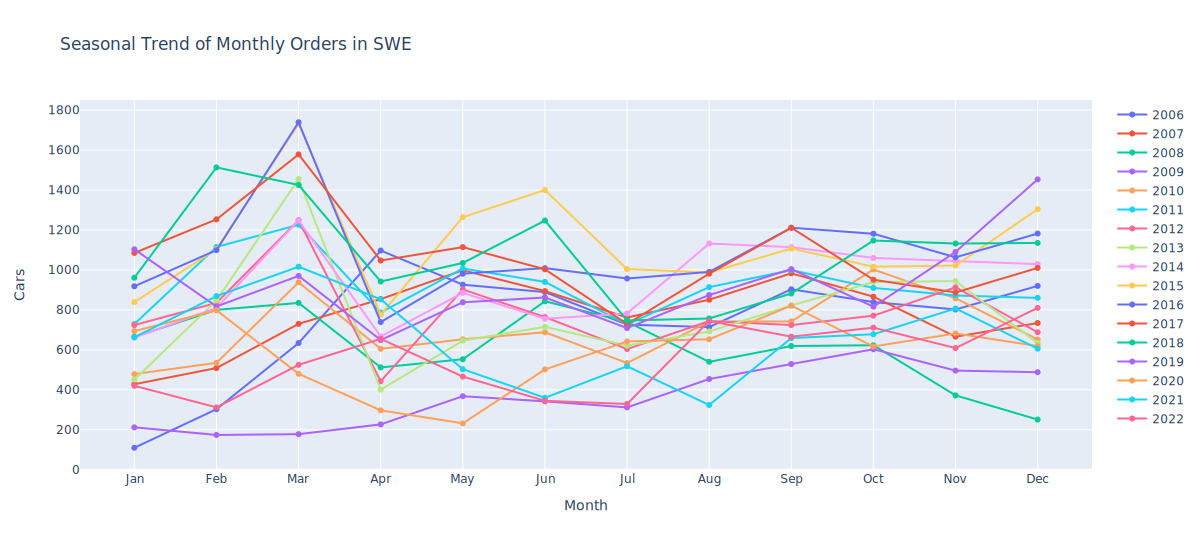

In [712]:
#Generate a widget
widget = widgets.IntRangeSlider(value=[2006, 2022], min=2006, max=2022, step=1, description='Time Period:', 
        disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')
widget

#Prepare Data
years = widget.value
years = list(range(years[0],years[1]+1))
df['Year'] = df.index.year
df['Month_'] = [d.strftime('%b') for d in df.index]

#Draw Plot
fig = go.Figure()
for i,y in enumerate(years):
    if i<len(years):
        fig.add_trace(go.Scatter(
            x=df[df['Year']==years[i]].Month_.tolist(),
            y=df[df['Year']==years[i]].Orders.round(2).tolist(),
            name=str(years[i])))
fig.update_layout(height=550, width=1200, title=go.layout.Title(text="Seasonal Trend of Monthly Orders in " + country),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Month')),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Cars')))
   
fig.show()

df.drop(['Month_', 'Year'], axis=1, inplace=True)

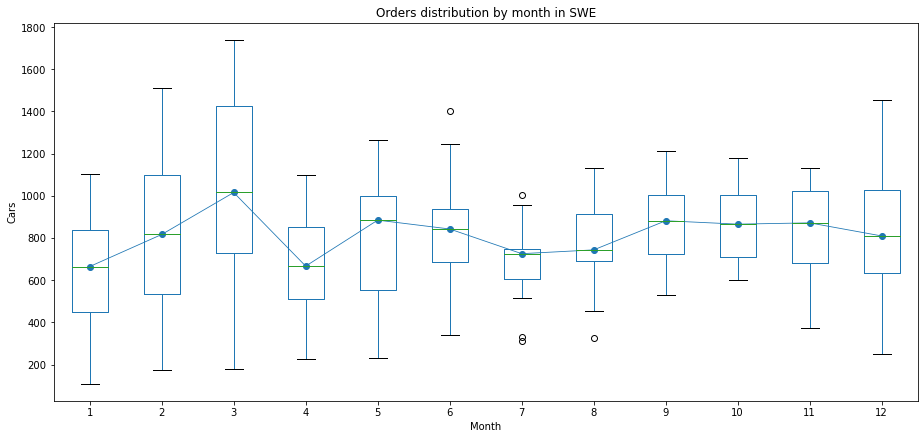

In [713]:
# Boxplot for annual seasonality
fig, ax = plt.subplots(figsize=(15, 7))
df['Month'] = df.index.month
df.boxplot(column='Orders', by='Month', ax=ax,)
df.groupby('Month')['Orders'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Cars')
ax.set_title('Orders distribution by month in ' + country)
fig.suptitle('');

### Trend

Rolling Statistics

A rolling average is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give us the annual rolling average.

We will also include the rolling standard deviation to see how much the data varies from the rolling average.

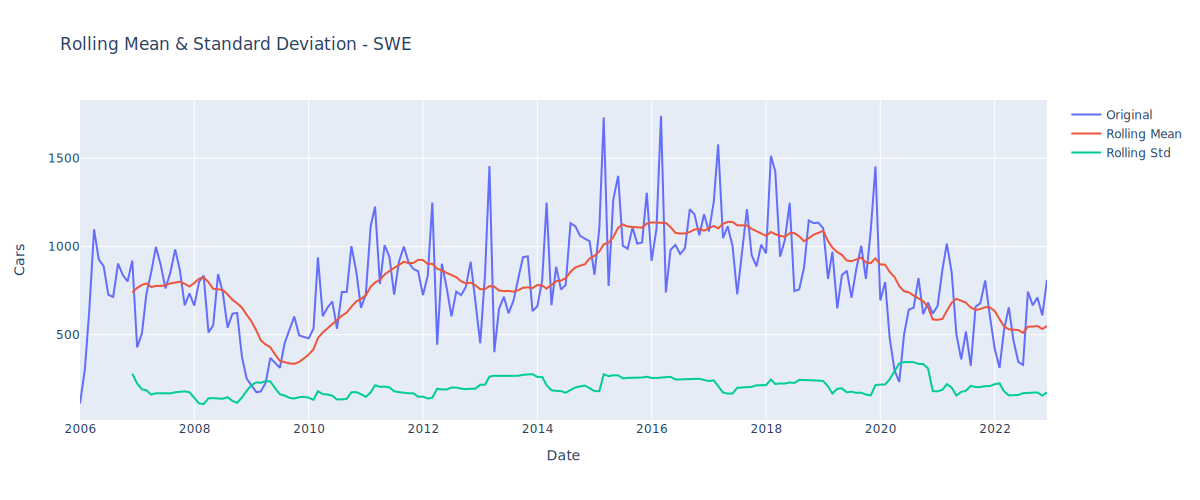

In [714]:
# Determine rolling statistics
# Wwindow size 12 denotes 12 months, giving rolling mean at yearly level
window_size = 12
df["rolling_avg"] = df['Orders'].rolling(window=window_size).mean() 
df["rolling_std"] = df['Orders'].rolling(window=window_size).std()

title = 'Rolling Mean & Standard Deviation - ' + country

fig= go.Figure()

fig.add_trace(go.Scatter(dict(x=df.index, y=df['Orders'], mode='lines', name= 'Original')))
fig.add_trace(go.Scatter(dict(x=df.index, y=df['rolling_avg'], mode='lines', name= 'Rolling Mean')))
fig.add_trace(go.Scatter(dict(x=df.index, y=df['rolling_std'], mode='lines', name= 'Rolling Std')))

fig.update_layout(height=500, width=1200, title=go.layout.Title(text=title),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date')),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Cars')))

fig.show()

df.drop(['rolling_avg', 'rolling_std'], axis=1, inplace=True)

### Time series decomposition 

We separate a time series into its components: trend, seasonality, and residuals. The trend represents the slow-moving changes in a time series. It is responsible for making the series gradually increase or decrease over time. The seasonality component represents the seasonal pattern in the series. The cycles occur repeatedly over a fixed period of time. The residuals represent the behavior that cannot be explained by the trend and seasonality components. They correspond to random errors, also termed white noise.

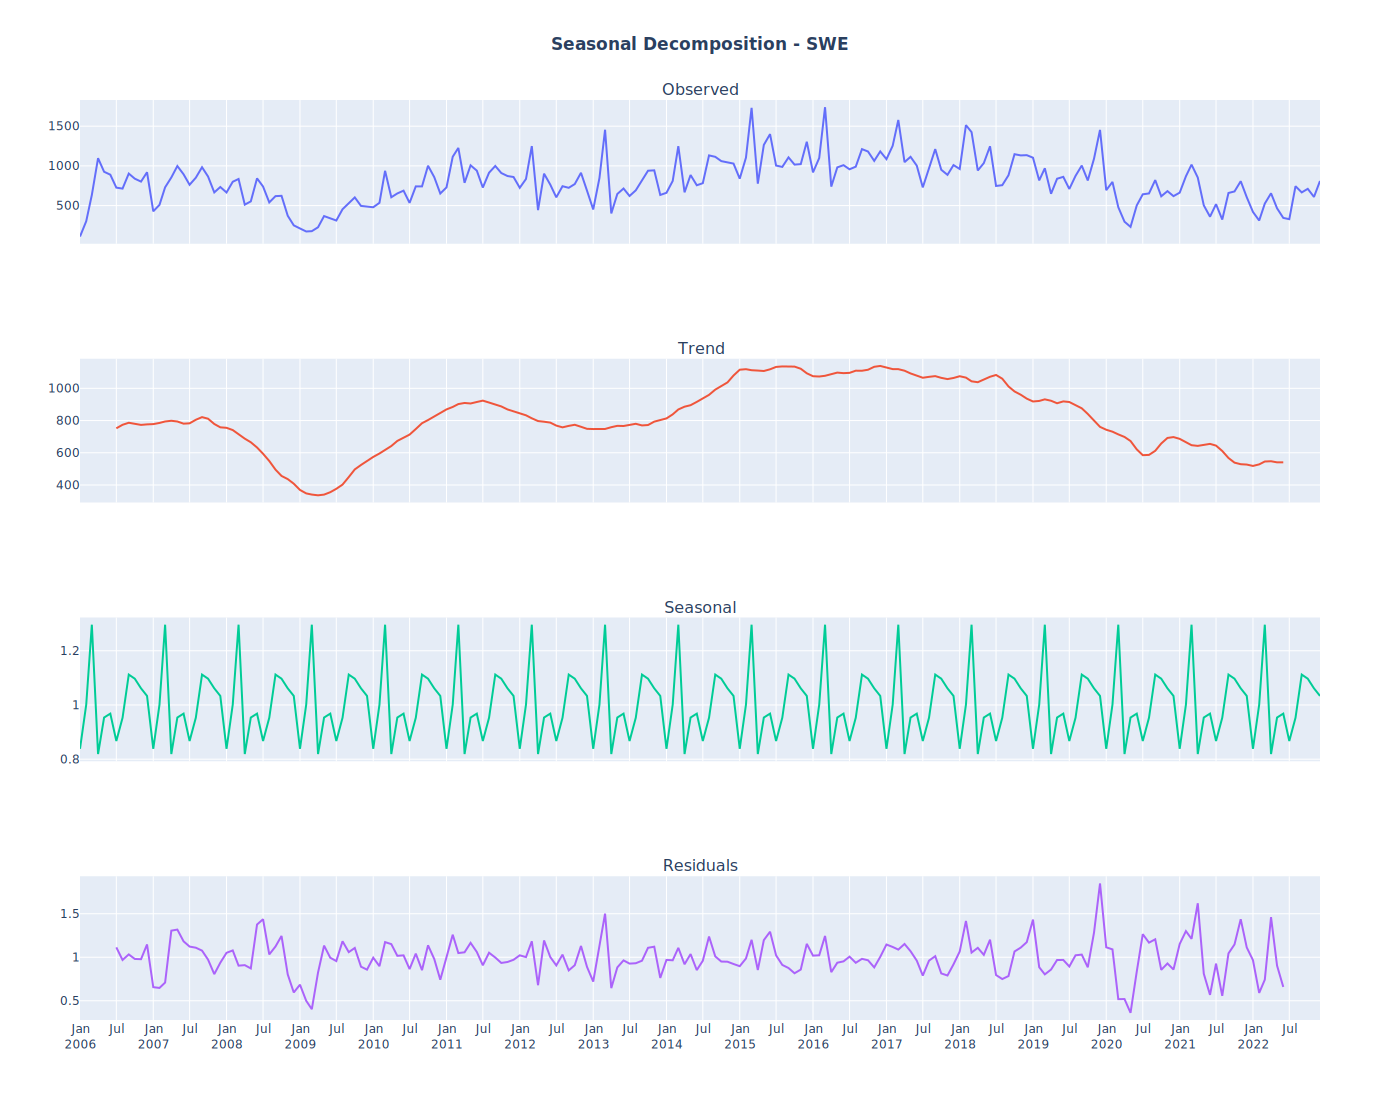

In [715]:
def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition - " + country):
    x_values = dates
    return (
        make_subplots(
            rows=4,
            cols=1,
            shared_xaxes=True,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'), row=1, col=1,)
        .add_trace(go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'), row=2, col=1,)
        .add_trace(go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'), row=3, col=1,)
        .add_trace(go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'), row=4, col=1,)
        .update_layout(height=1100, width=1400, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False)
        .update_xaxes(dtick="M6",tickformat="%b\n%Y")        
    )

decomposition = seasonal_decompose(df['Orders'], model='multiplicative', period=12)
fig = plot_seasonal_decompose(decomposition, dates=df.index)
fig.show()    

### Stationarity (Augmented Dickey–Fuller Test)

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

* Null Hypothesis: The data is not stationary.

* Alternative Hypothesis: The data is stationary.

For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:

* p-value <= significance level (0.01, 0.05, 0.10, etc.)

If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

Results of Dickey-Fuller Test:
Test Statistic                  -1.657104
p-value                          0.453338
#Lags Used                      12.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


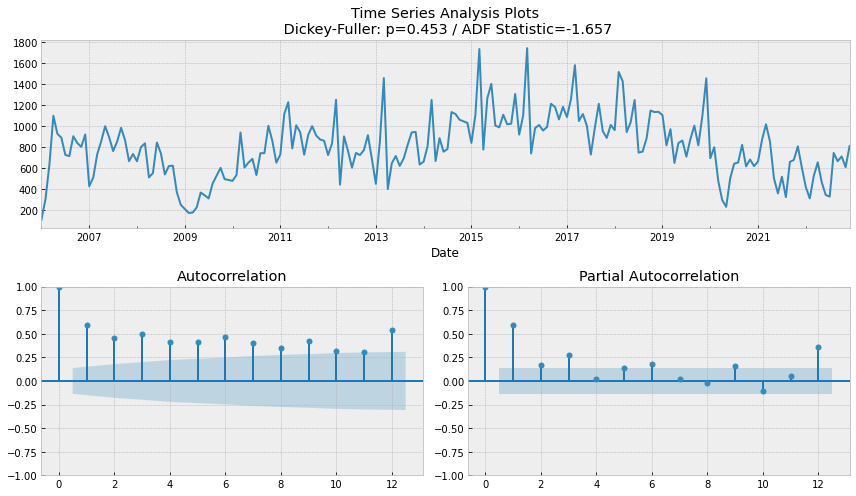

In [716]:
# Time series analysis plot
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        result = adfuller(y, autolag='AIC',regression='c')
        adf = result[0]
        p_value = result[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.3f} / ADF Statistic={1:.3f}'.format(p_value, adf))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()
        
# Data Stationarity check using Augmented Dickey Fuller(ADF) test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC',regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return dfoutput['p-value']

tsplot(df['Orders'], lags=12)
p_value = adf_test(df['Orders'])     

Results of Dickey-Fuller Test:
Test Statistic                  -5.063210
p-value                          0.000017
#Lags Used                      11.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


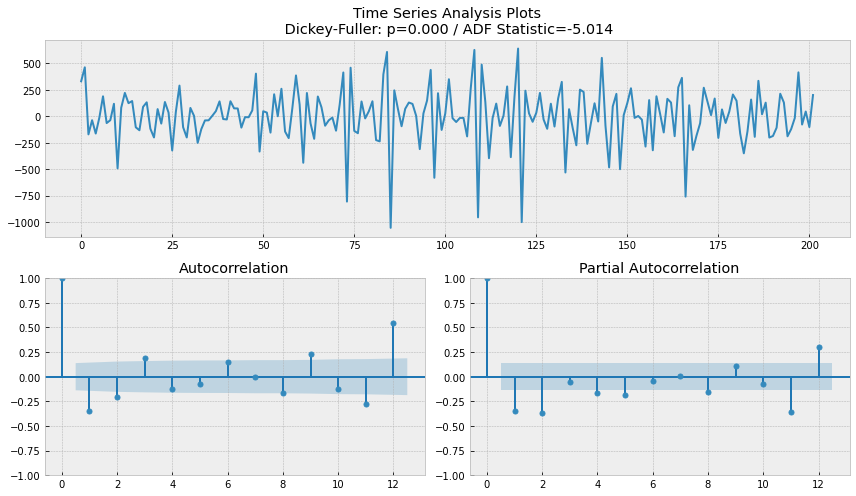

In [717]:
if p_value > 0.05:
    # Take the first difference to make our series stationary    
    data_diff = np.diff(df['Orders'],1)
    tsplot(data_diff[1:], lags=12)
    p_value = adf_test(data_diff)  

### Correlation plots

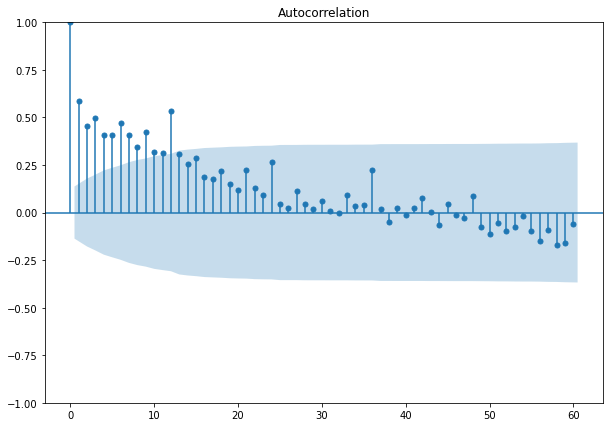

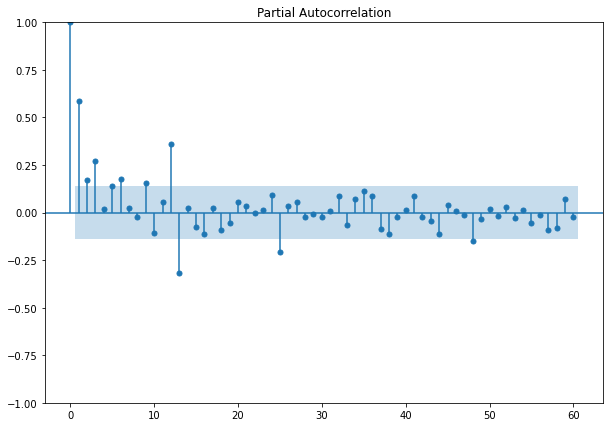

In [718]:
# Autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 7))
plot_acf(df['Orders'], ax=ax, lags=60)

# Partial autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 7))
plot_pacf(df['Orders'], ax=ax, lags=60, method='ywm')
plt.show()

In [719]:
df.drop('Month', axis=1, inplace=True)

In [720]:
df

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01-01,110,0.611753,8.1,3.32,63.568847
2006-02-01,303,0.608882,7.3,3.42,67.391665
2006-03-01,634,1.122431,7.6,3.55,92.858327
2006-04-01,1097,1.484866,8.0,3.84,95.325089
2006-05-01,926,1.573034,7.4,3.89,107.940718
...,...,...,...,...,...
2022-08-01,744,9.831681,7.0,1.61,71.260900
2022-09-01,666,10.837620,7.1,2.08,76.413249
2022-10-01,711,10.853250,7.7,2.20,76.986837


In [721]:
# Save data to Excel so we don't need to run these steps every time
#df.to_excel("Datasets/Output_files/1.xlsx") 

# Save data to Excel  
with pd.ExcelWriter("Datasets/Output_files/1.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df.to_excel(writer, sheet_name=country)    

In [722]:
Orders = df[['Orders']]

In [723]:
Orders

,Orders
Date,
2006-01-01,110
2006-02-01,303
2006-03-01,634
2006-04-01,1097
2006-05-01,926
...,...
2022-08-01,744
2022-09-01,666
2022-10-01,711


In [724]:
# Save data to Excel  
with pd.ExcelWriter("Datasets/Output_files/Orders.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    Orders.to_excel(writer, sheet_name=country) 

### Pandas profiling

In [725]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [726]:
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


### Summary Tools

In [727]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Orders[int64],Mean (sd) : 804.8 (292.4)min < med < max:110.0 < 804.5 < 1739.0IQR (CV) : 358.0 (2.8),185 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABXUlEQVR4nO3cMU7DMBiG4R+ElMWs6cCCfAG4ACdg4gRee6ZsOQGn4B4sDGT2EilSOjCn2G2SJv7eZ/Zg9ZUcx1Z6N46joXz3t54A1vFw6wmcU9f1h3PukDI2xvjbdd3n0nPaq02Hds4dQgg/KWPbtn1aej57xtItgtAiCC2C0CIILWLTu+4cfd+/eu+PKWMVX8WKCV1V1SOvYtNYukUQWgShRRBaBKFFEFoEoUUQWkQxByY5FE/RJEMrnqKxdIsgtAhCiyC0CEKLILQIQosgtAhCiyC0CMkj0BylnIsT+h+lnIuvHjrnU9hhGF7MLOlHxnmrh878FPZt6fmoYDMmgtAiZlm6ee5u3yyhee5uH0u3CEKLILQIQosgtIjJXTevTGWZDM0rU1m4vZpRzpWmmVmM8dk595049qorUELPKOdK0+xvJQwhfKWMbZrm3Xt/8R/gEnonrr0XZ9ct4gQrDnw5iisrzQAAAABJRU5ErkJggg=="">",0(0.0%)
2,CPI[float64],Mean (sd) : 1.7 (2.1)min < med < max:-1.9 < 1.5 < 11.5IQR (CV) : 1.8 (0.8),204 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABOElEQVR4nO3cMWrDMBhAYbcU7EFdnaFL8QXSC/QQPYHWXMsn6NbzdOlQz14MBnfM0hiJKG7S9775BxseyCAh3y3LUun/u//rF9A2HrZ+YNu2byGEXcrsOI7fwzC8X/qdCDYPHULYxRi/Umb7vn+69PtQuHRDGBrC0BCGhjA0hKEhDA1haAhDQxgawtAQRfa6cw4q5nneV1WVtNetcoqEzjyoeC3xTOVx6YYwNIShIQwNYWgIQ0MYGsLQEIaGMDSEoSEMDWFoCENDGBpi80t2OaZpeum67pAy683LdVcduq7rR29eluHSDWFoCENDGBrC0BCGhjA0hKEhDA1haAhDQ5zc6761G5IegKw7GfrWbkh6ALLOpRviqo8pdXTuX5GRoTO/588hhM/Ss7nzTdPsY4wfKbO/fZp+ABkSXJES2tToAAAAAElFTkSuQmCC"">",0(0.0%)
3,UR[float64],Mean (sd) : 7.6 (0.9)min < med < max:5.8 < 7.7 < 9.5IQR (CV) : 1.3 (8.5),37 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABUElEQVR4nO3aMU6EQBSA4dGY0GDLFnZcQC/gITzBtl6LE3gqC6lpSEjwBBuZLAzP+f+vppjk333wCA/ruibV7/HsA6iMp7MPcIau6z7atr1suXaapp9xHL+OPtPRkKHbtr1cr9fvLdcOw/By9HlKcHRDGBoCObpzzPP81vf955ZrI9/PDf2Hpmmea7ifO7ohiv+jiatNBMVDE1ebCBzdEIaGMDSEoSEMDRH6hUktb6UiCB26lrdSETi6IQwNYWgIQ0MYGsLQEKHXqxw5O/eyLK8ppU1rWy2qCZ25c78ffZ5oHN0QhoaoZnT/RyU/qzL0iUp+VuXohtjlH50zgoirTQS7hM4cQdWuNjm7fEplf/Teo3eUs8unVPZH7z0awtAQN0e3D1ix3Pv93M3QPmDFcu/3c45uCENDGBrC0BCGhjA0hKEhDA1haAhDQxgawtAQv0d1gLt03GGYAAAAAElFTkSuQmCC"">",0(0.0%)
4,LTIR[float64],Mean (sd) : 1.8 (1.4)min < med < max:-0.3 < 1.6 < 4.5IQR (CV) : 2.6 (1.3),167 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABXUlEQVR4nO3av22EMBiGcSeKRPOl5Yo0EQskC2SIm8Bt1mKCTJE90qQINQ0SEpngkD9hjI/3+dXWgfScjfnzsCxLwPk9Hn0CKOMpx4+0bXs1s0vK2HEc/4Zh+MpxXKTLEtrMLjHG35Sxfd+/5DgmfFi6RRBaBKFFEFoEoUUQWkSW2yuPaZreu677TBnLPXc+xUM3TfPMPXd5LN0ibs5oz2PNeZ7fQghJsxTHuBna+VjzI98pYQ8s3SIILYLQIggtovh99F74+GHdaULz8cM6lm4RhBZxmqW7Bp59Qghl9wqEzsizTwih7F6B0Acq+cqW0Acq+cqW0Hdi6+wn9J3YOvurDu35F/NOfF3VoZ3/Yt6Jr+CBiYiqZ/RenBubVzP7SRlb8+VDMrT3khBj/E4du+3M9sPSLYLQIggtgtAiCC2C0CIILYLQIggtgtAiCC2C0CIILYLQIggtgtAi/gF6aH+MehAMuAAAAABJRU5ErkJggg=="">",0(0.0%)
5,TIV[float64],Mean (sd) : 89.4 (21.5)min < med < max:41.0 < 88.3 < 224.0IQR (CV) : 25.8 (4.2),202 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABIUlEQVR4nO3cMY6CQBhAYTQmNGOLhR0XcC/gITwB7V6LE3gqC6lpSEjYE0iY7IBk3vvqSZjkxYnmHzxM01Qof8dvb0DbOG39wKqqHiGEy5K1fd+/u657rr0ngs1DhxAuTdO8lqxt2/a69n4oPLohDA1haAhDQxgawtAQhoYwNIShIQwNYWgIQ0MYGiLJ9Cpm9DiO460oikXTK6WTJHTk6PGe4pmKs/k8OsYwDD91Xf8uWeslhXm7Dl2W5dlLCmn4ZQzC0BCGhjA0hKEhDA1haAhDQxgawtAQhoYwNIShIQwNYWgIQ0MYGsLQEIaGMDTEri8HxvDG6LxsQntjdJ5HN8THT7Sv2eTlY2hfs8mLRzeEoSEMDZHNz6u17OVvp/+7jz

### Feature engineering

In [728]:
df_fe = df.copy()

In [729]:
df_fe

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01-01,110,0.611753,8.1,3.32,63.568847
2006-02-01,303,0.608882,7.3,3.42,67.391665
2006-03-01,634,1.122431,7.6,3.55,92.858327
2006-04-01,1097,1.484866,8.0,3.84,95.325089
2006-05-01,926,1.573034,7.4,3.89,107.940718
...,...,...,...,...,...
2022-08-01,744,9.831681,7.0,1.61,71.260900
2022-09-01,666,10.837620,7.1,2.08,76.413249
2022-10-01,711,10.853250,7.7,2.20,76.986837


In [730]:
# Feature engineering
df_fe['Quarter'] = pd.PeriodIndex(df_fe.index, freq='Q').quarter
df_fe['Month'] = pd.PeriodIndex(df_fe.index, freq='M').month
#df_fe['Year'] = pd.PeriodIndex(df_fe.index, freq='Y').year

#df_fe['Orders_lagged_1m'] = df_fe['Orders'].shift(1)
df_fe['Orders_lagged_12m'] = df_fe['Orders'].shift(12)

for i in range (3,6):
    df_fe['LTIR_lagged_' + str(i) + 'm'] = df_fe.LTIR.shift(i)       
    df_fe['CPI_lagged_' + str(i) + 'm'] = df_fe.CPI.shift(i)
    df_fe['UR_lagged_' + str(i) + 'm'] = df_fe.UR.shift(i)

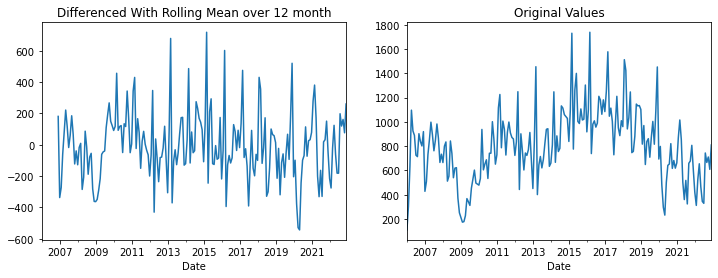

In [731]:
# Remove trend
rolling_mean = df.Orders.rolling(window = 12).mean()
df_fe['Orders_rolled_detrended'] = df_fe.Orders - rolling_mean
ax1 = plt.subplot(121)
df_fe['Orders_rolled_detrended'].plot(figsize=(12,4), title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
df_fe.Orders.plot(figsize=(12,4), title="Original Values", ax=ax2);

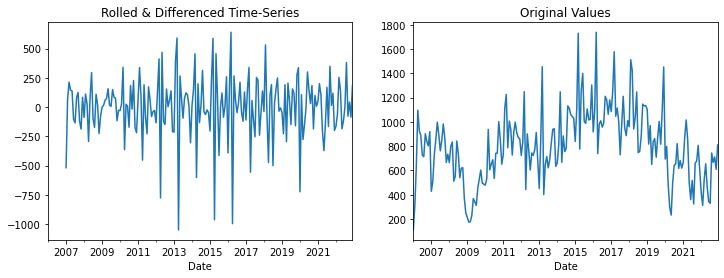

In [732]:
# Remove seasonality
# Differencing Over Time-Series with Rolling Mean taken over 12 Months
df_fe['Orders_rolled_detrended_diff'] = df_fe.Orders_rolled_detrended - df_fe.Orders_rolled_detrended.shift()

ax1 = plt.subplot(121)
df_fe.Orders_rolled_detrended_diff.plot(figsize=(8,4), title="Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
df_fe.Orders.plot(figsize=(12,4), title="Original Values", ax=ax2);

In [733]:
df_fe

,Orders,CPI,UR,LTIR,TIV,Quarter,Month,Orders_lagged_12m,LTIR_lagged_3m,CPI_lagged_3m,UR_lagged_3m,LTIR_lagged_4m,CPI_lagged_4m,UR_lagged_4m,LTIR_lagged_5m,CPI_lagged_5m,UR_lagged_5m,Orders_rolled_detrended,Orders_rolled_detrended_diff
Date,,,,,,,,,,,,,,,,,,,
2006-01-01,110,0.611753,8.1,3.32,63.568847,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-01,303,0.608882,7.3,3.42,67.391665,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-01,634,1.122431,7.6,3.55,92.858327,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-04-01,1097,1.484866,8.0,3.84,95.325089,2,4,NaN,3.32,0.611753,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-01,926,1.573034,7.4,3.89,107.940718,2,5,NaN,3.42,0.608882,7.3,3.32,0.611753,8.1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,744,9.831681,7.0,1.61,71.260900,3,8,324.0,1.77,7.266010,7.8,1.47,6.360725,7.7,0.82,5.966897,7.6,198.500000,380.000000
2022-09-01,666,10.837620,7.1,2.08,76.413249,3,9,659.0,1.86,8.681004,7.6,1.77,7.266010,7.8,1.47,6.360725,7.7,119.916667,-78.583333
2022-10-01,711,10.853250,7.7,2.20,76.986837,4,10,678.0,1.53,8.488443,7.0,1.86,8.681004,7.6,1.77,7.266010,7.8,162.166667,42.250000


In [734]:
df_fe.dropna(inplace=True)

In [735]:
df_fe.columns

Index(['Orders', 'CPI', 'UR', 'LTIR', 'TIV', 'Quarter', 'Month',
       'Orders_lagged_12m', 'LTIR_lagged_3m', 'CPI_lagged_3m', 'UR_lagged_3m',
       'LTIR_lagged_4m', 'CPI_lagged_4m', 'UR_lagged_4m', 'LTIR_lagged_5m',
       'CPI_lagged_5m', 'UR_lagged_5m', 'Orders_rolled_detrended',
       'Orders_rolled_detrended_diff'],
      dtype='object')

In [736]:
variables = ['CPI', 'UR', 'LTIR', 'TIV']
for v in variables:
    df_fe[v + '_diff'] = df_fe[v].diff(periods=1)
    rolling_mean = df[v].rolling(window = 12).mean()
    df_fe[v + '_rolled_detrended'] = df_fe[v] - rolling_mean
    df_fe[v + '_rolled_detrended_diff'] = df_fe[v + '_rolled_detrended'] - df_fe[v + '_rolled_detrended'].shift()

In [737]:
df_fe = df_fe.dropna()

In [738]:
df_fe.columns

Index(['Orders', 'CPI', 'UR', 'LTIR', 'TIV', 'Quarter', 'Month',
       'Orders_lagged_12m', 'LTIR_lagged_3m', 'CPI_lagged_3m', 'UR_lagged_3m',
       'LTIR_lagged_4m', 'CPI_lagged_4m', 'UR_lagged_4m', 'LTIR_lagged_5m',
       'CPI_lagged_5m', 'UR_lagged_5m', 'Orders_rolled_detrended',
       'Orders_rolled_detrended_diff', 'CPI_diff', 'CPI_rolled_detrended',
       'CPI_rolled_detrended_diff', 'UR_diff', 'UR_rolled_detrended',
       'UR_rolled_detrended_diff', 'LTIR_diff', 'LTIR_rolled_detrended',
       'LTIR_rolled_detrended_diff', 'TIV_diff', 'TIV_rolled_detrended',
       'TIV_rolled_detrended_diff'],
      dtype='object')

### Feature Selection

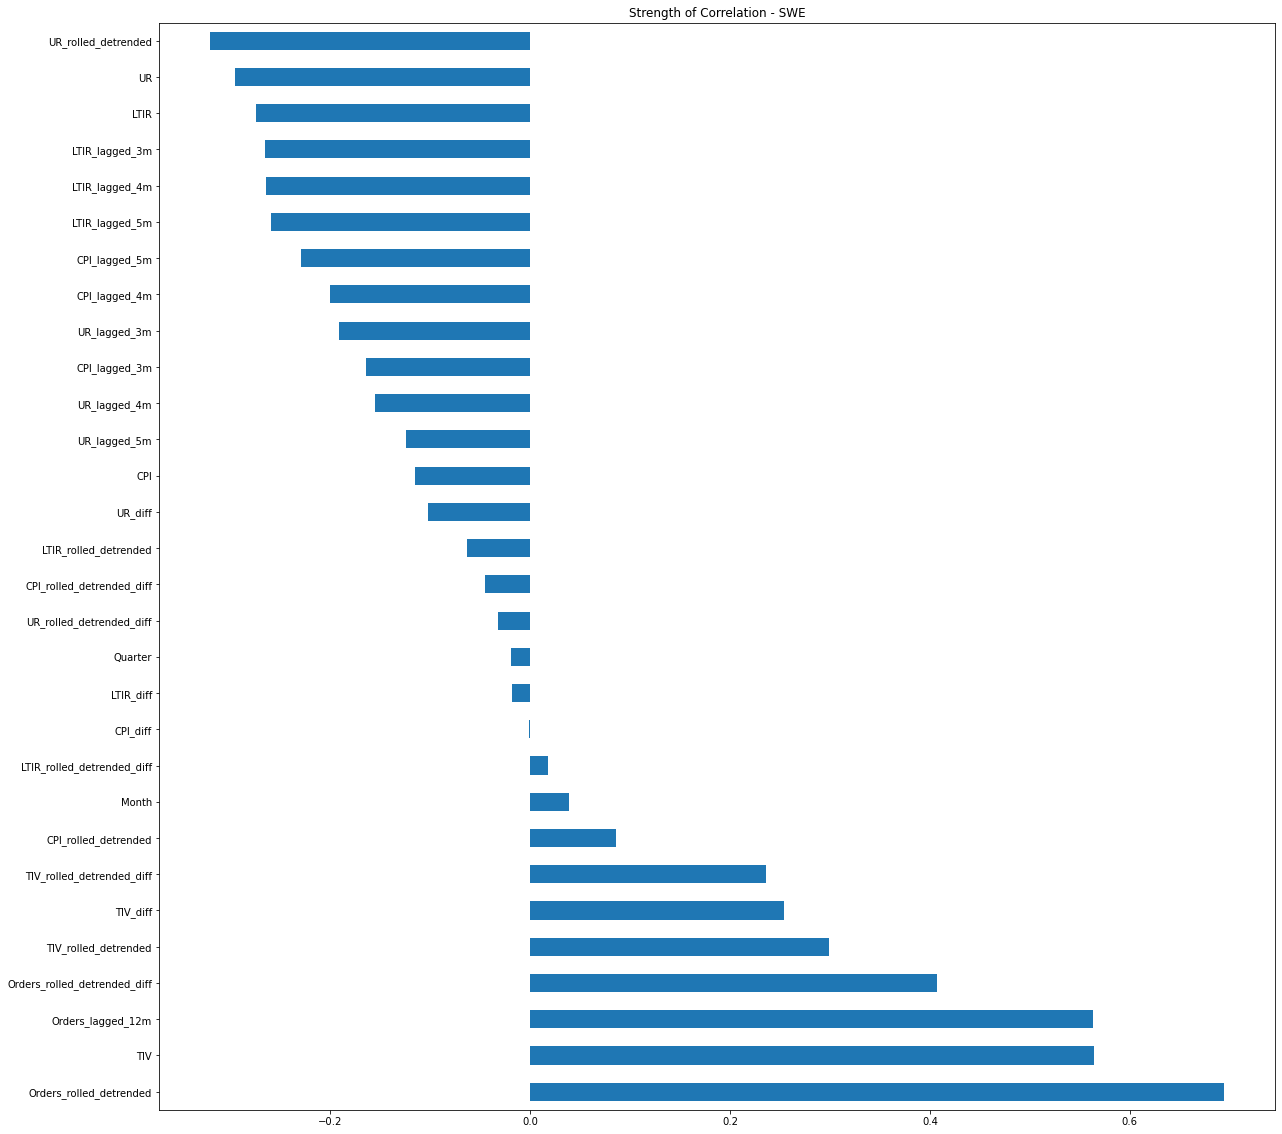

In [739]:
figure(figsize=(20, 20))

corr = df_fe.loc[:, df_fe.columns != 'Orders'].corrwith(df_fe.Orders)
corr.sort_values(ascending=False).plot.barh(title = 'Strength of Correlation - ' + country);

In [740]:
df_fe = df.copy()

In [741]:
# We keep only the meaningfull features
rolling_mean = df.Orders.rolling(window = 12).mean()
df_fe['Orders_rolled_detrended'] = df_fe.Orders - rolling_mean

rolling_mean = df.TIV.rolling(window = 12).mean()
df_fe['TIV_rolled_detrended'] = df_fe.TIV - rolling_mean

df_fe['Orders_lagged_12m'] = df_fe['Orders'].shift(12)

In [742]:
df_fe = df_fe.dropna()

In [743]:
df_fe

,Orders,CPI,UR,LTIR,TIV,Orders_rolled_detrended,TIV_rolled_detrended,Orders_lagged_12m
Date,,,,,,,,
2007-01-01,428,1.938553,6.7,3.90,75.809821,-337.083333,-11.917708,110.0
2007-02-01,509,1.975792,6.4,3.93,74.503498,-273.250000,-13.816684,303.0
2007-03-01,730,1.923009,6.7,3.79,101.452206,-60.250000,12.415868,634.0
2007-04-01,854,1.923889,6.3,4.04,101.233381,84.000000,11.704685,1097.0
2007-05-01,998,1.657536,6.1,4.15,111.156792,222.000000,21.360090,926.0
...,...,...,...,...,...,...,...,...
2022-08-01,744,9.831681,7.0,1.61,71.260900,198.500000,-7.700894,324.0
2022-09-01,666,10.837620,7.1,2.08,76.413249,119.916667,-2.355691,659.0
2022-10-01,711,10.853250,7.7,2.20,76.986837,162.166667,-2.418686,678.0


In [744]:
# Save data to Excel  
with pd.ExcelWriter("Datasets/Output_files/2.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df_fe.to_excel(writer, sheet_name=country) 